Transfer Learning Using VGG16

Importing libraries

In [1]:
import tensorflow as tf

In [2]:

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [3]:
ROOT_PATH='E:/Projects/Dog_breed_classification'

Change the directory to root path

In [4]:
import os
os.chdir(ROOT_PATH)
os.getcwd()

'E:\\Projects\\Dog_breed_classification'

Since the data was downloaded from kaggle the format isnt as expected for the project so we need to first download the data then process it for our analysis.

In [27]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("darshanthakare/dog-breeds-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\athar\.cache\kagglehub\datasets\darshanthakare\dog-breeds-image-dataset\versions\1


Now we move the dataset to the directory and process to train test split

In [28]:
source_dir = r'E:\Projects\Dog_breed_classification\Images'
dest_dir=os.path.join(ROOT_PATH, 'Dataset')

# Create subfolder
train_dir=os.path.join(dest_dir, 'train')
val_dir=os.path.join(dest_dir, 'val')

# Create folders if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

Now we loop over each breed folder and process it

In [29]:
import shutil
import random

random.seed(42)

for folder in os.listdir(source_dir):
    folder_path= os.path.join(source_dir, folder)

    # skip if not a folder
    if not os.path.isdir(folder_path):
        continue

    # Extract Breed name (after dash)
    if '-' in folder:
        breed_name = folder.split('-')[-1].strip()
    else:
        continue # Skip if no breed name found

    # Create breed subfolders in train and val directories
    train_breed_dir = os.path.join(train_dir, breed_name)
    val_breed_dir = os.path.join(val_dir, breed_name)
    os.makedirs(train_breed_dir, exist_ok=True)
    os.makedirs(val_breed_dir, exist_ok=True)

    # List .jpg files
    images=[img for img in os.listdir(folder_path) if img.lower().endswith('.jpg')]
    random.shuffle(images)

    # Train val split

    split_idx=int(len(images) * 0.8)
    train_images = images[:split_idx]
    val_images = images[split_idx:]

    # Copy train images
    for img in train_images:
        src = os.path.join(folder_path, img)
        dest = os.path.join(train_breed_dir, img)
        shutil.copy(src, dest)

    # Copy val images
    for img in val_images:
        src = os.path.join(folder_path, img)
        dest = os.path.join(val_breed_dir, img)
        shutil.copy(src, dest)

    print(f"Processed {breed_name}: {len(train_images)} train, {len(val_images)} val")
print("Dataset preparation complete.")

Processed beagle: 145 train, 37 val
Processed German_shepherd: 119 train, 30 val
Processed Doberman: 109 train, 28 val
Processed Siberian_husky: 132 train, 34 val
Processed Pomeranian: 163 train, 41 val
Dataset preparation complete.


In [5]:
# Resize all images to this size
IMAGE_SIZE = [224, 224]

train_path= 'Dataset/train'
valid_path= 'Dataset/val'

Import the VGG library and use the imagenet weights for the network.

In [6]:
vgg=VGG16(input_shape=IMAGE_SIZE+[3],weights='imagenet',include_top=False)

Now we fix the weights to initiate transfer learning

In [7]:
for layer in vgg.layers:
    layer.trainable=False

In [8]:
# Check if weights have been fixed
for i in vgg.layers:
    print(i,i.trainable)

<InputLayer name=input_layer, built=True> False
<Conv2D name=block1_conv1, built=True> False
<Conv2D name=block1_conv2, built=True> False
<MaxPooling2D name=block1_pool, built=True> False
<Conv2D name=block2_conv1, built=True> False
<Conv2D name=block2_conv2, built=True> False
<MaxPooling2D name=block2_pool, built=True> False
<Conv2D name=block3_conv1, built=True> False
<Conv2D name=block3_conv2, built=True> False
<Conv2D name=block3_conv3, built=True> False
<MaxPooling2D name=block3_pool, built=True> False
<Conv2D name=block4_conv1, built=True> False
<Conv2D name=block4_conv2, built=True> False
<Conv2D name=block4_conv3, built=True> False
<MaxPooling2D name=block4_pool, built=True> False
<Conv2D name=block5_conv1, built=True> False
<Conv2D name=block5_conv2, built=True> False
<Conv2D name=block5_conv3, built=True> False
<MaxPooling2D name=block5_pool, built=True> False


In [9]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Now get the number of classes

In [10]:
folders=glob('Dataset/train/*')

In [11]:
folders

['Dataset/train\\beagle',
 'Dataset/train\\Doberman',
 'Dataset/train\\German_shepherd',
 'Dataset/train\\Pomeranian',
 'Dataset/train\\Siberian_husky']

In [12]:
len(folders)

5

We have total 5 classes that is we have images of 5 Dog breeds

Now we start building our model and then train it.

As our data has over 500 images there is a chance of overfitting. Hence we add one dense layers and one dropout layer and then the finally the softmax activation layer with 24 classes.

In [13]:
model=Sequential()

model.add(vgg)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(folders), activation='softmax'))

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,757 (80.64 MB)

 Trainable params: 6,424,069 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [15]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [16]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('Dataset/train',target_size = (224, 224), batch_size = 32, class_mode = 'categorical')

Found 154 images belonging to 5 classes.


In [18]:
test_set = test_datagen.flow_from_directory('Dataset/val',target_size = (224, 224),batch_size = 32,class_mode = 'categorical')

Found 136 images belonging to 5 classes.


Now we fit the model

In [20]:
r = model.fit(training_set,validation_data=test_set,epochs=15,steps_per_epoch=len(training_set),validation_steps=len(test_set))

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 8s/step - accuracy: 0.8732 - loss: 0.4089 - val_accuracy: 0.7132 - val_loss: 0.8326
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - accuracy: 0.9176 - loss: 0.3145 - val_accuracy: 0.6912 - val_loss: 0.8271
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 9s/step - accuracy: 0.9128 - loss: 0.2945 - val_accuracy: 0.6912 - val_loss: 0.8242
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - accuracy: 0.8997 - loss: 0.2838 - val_accuracy: 0.7059 - val_loss: 0.8287
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - accuracy: 0.9527 - loss: 0.2428 - val_accuracy: 0.7353 - val_loss: 0.7793
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - accuracy: 0.9494 - loss: 0.2127 - val_accuracy: 0.7132 - val_loss: 0.8083
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - accuracy: 0.9457 - loss: 0.2199 - val_accuracy: 0.7059 - val_loss: 0.8043
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - accuracy: 0.9559 - loss: 0.1937 - val_accuracy: 0.7059 - val_loss: 0.7794
Epoch 9/

In [21]:

import matplotlib.pyplot as plt

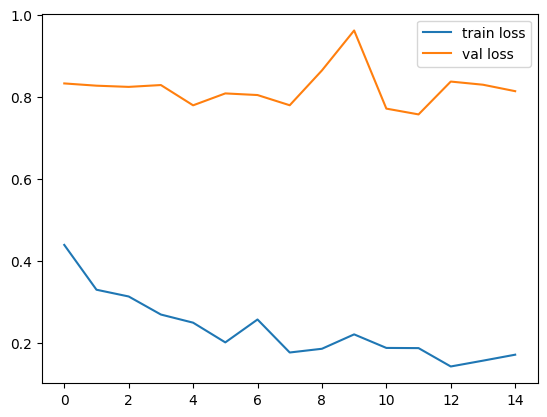

<Figure size 640x480 with 0 Axes>

In [22]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

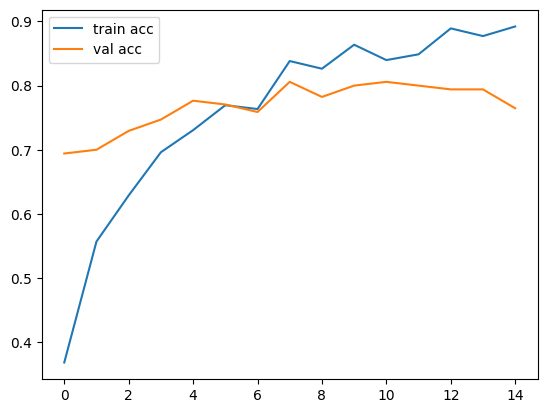

<Figure size 640x480 with 0 Axes>

In [47]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [48]:
# Save this model as it has accuracy of 81%

In [23]:

model_dir= os.path.join(ROOT_PATH, 'Models')
os.makedirs(model_dir, exist_ok=True)

In [24]:
from tensorflow.keras.models import load_model

model.save('Models/model_vgg16.h5')

In [25]:
y_pred = model.predict(test_set)

5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step


In [26]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [27]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [28]:
model=load_model('Models/model_vgg16.h5')

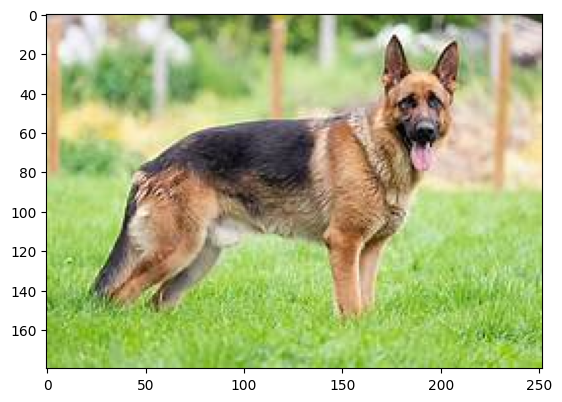

In [29]:
Z = plt.imread('GSD2.jpeg')
plt.imshow(Z)

In [30]:
import json
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load class names (sorted in training)
class_names = sorted(os.listdir("Dataset/train"))

# Load and preprocess the image
def predict_image(img_path, model):
    img = load_img(img_path, target_size=(224, 224))  # Ensure same size
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    # Predict
    preds = model.predict(img)
    pred_index = np.argmax(preds, axis=1)[0]
    confidence = preds[0][pred_index]

    # Map to class name
    predicted_breed = class_names[pred_index]
    print(f"Predicted breed: {predicted_breed} (Confidence: {confidence:.2f})")
    return predicted_breed


In [31]:

# Example usage
predict_image("GSD2.jpeg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
Predicted breed: German_shepherd (Confidence: 1.00)


'German_shepherd'

The predictions are good. The model needs more spohisticated training and prefererably training the VGG16 architecture from scrath without using imagenet weights but there is computing limitation for this project. Hence we use this model for predictions and build a flask API.